In [251]:
import torch
import math
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

In [387]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=3.0)

In [388]:
x, z = X[:, 0], X[:, 1]

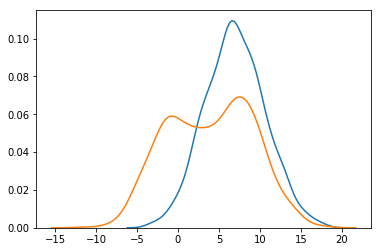

In [389]:
sns.kdeplot(x)
sns.kdeplot(z)

In [390]:
x = torch.from_numpy(x).type(torch.float64)
z = torch.from_numpy(z).type(torch.float64)
y = torch.from_numpy(y).type(torch.float64)

# something like naive bayes, but features are normally distributed

In [391]:
#params
pnorm = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([1.]))

p = torch.tensor(0.2).type(torch.float64)
mu1x = torch.randn(1).type(torch.float64)
mu1z = torch.randn(1).type(torch.float64)
mu2x = torch.randn(1).type(torch.float64)
mu2z = torch.randn(1).type(torch.float64)
sigm1x = pnorm.sample().type(torch.float64)
sigm2x = pnorm.sample().type(torch.float64)
sigm1z = pnorm.sample().type(torch.float64)
sigm2z = pnorm.sample().type(torch.float64)

p.requires_grad = True
mu1x.requires_grad = True
mu1z.requires_grad = True
mu2x.requires_grad = True
mu2z.requires_grad = True
sigm1x.requires_grad = True
sigm2x.requires_grad = True
sigm1z.requires_grad = True
sigm2z.requires_grad = True

def likelihood():
    L = (y*torch.log2(p) + (1 - y)*torch.log2(1 - p))
    
    lx1 = y * (-torch.log2(sigm1x) - 1/(2 * sigm1x ** 2) * (x - mu1x) ** 2)
    lx2 = (1-y) * (-torch.log2(sigm2x) - 1/(2 * sigm2x ** 2) * (x - mu2x) ** 2)
    
    lz1 = y * (-torch.log2(sigm1z) - 1/(2 * sigm1z ** 2) * (z - mu1z) ** 2)
    lz2 = (1-y) * (-torch.log2(sigm2z) - 1/(2 * sigm2z ** 2) * (z - mu2z) ** 2)
    
    return torch.mean(L * (lx1 + lx2 + lz1 + lz2))

In [392]:
L = likelihood()
L.backward()

In [393]:
sigm1x.grad, sigm2x.grad, sigm1z.grad, sigm2z.grad

(tensor([-4.2852], dtype=torch.float64),
 tensor([-0.0161], dtype=torch.float64),
 tensor([0.0705], dtype=torch.float64),
 tensor([-0.1929], dtype=torch.float64))

In [394]:
gamma = 0.01
for i in range(10000):
    L = likelihood()
    L.backward()
    
    #gamma -= i / 500000
    with torch.no_grad():
        p = p - gamma * p.grad
        mu1x = mu1x - gamma * mu1x.grad
        mu1z = mu1z - gamma * mu1z.grad
        mu2x = mu2x - gamma * mu2x.grad
        mu2z = mu2z - gamma * mu2z.grad
        sigm1x = sigm1x - gamma * sigm1x.grad
        sigm2x = sigm2x - gamma * sigm2x.grad
        sigm1z = sigm1z - gamma * sigm1z.grad
        sigm2z = sigm2z - gamma * sigm2z.grad
        
    p.requires_grad = True
    mu1x.requires_grad = True
    mu1z.requires_grad = True
    mu2x.requires_grad = True
    mu2z.requires_grad = True
    sigm1x.requires_grad = True
    sigm2x.requires_grad = True
    sigm1z.requires_grad = True
    sigm2z.requires_grad = True

In [395]:
def F(x, sigm, mu):
    return 1/(math.sqrt(2 * math.pi) * sigm) * torch.exp(-1/(2*sigm**2) * (x - mu) ** 2)

In [396]:
a = torch.log2(F(x, sigm2x, mu2x) * F(z, sigm2z, mu2z) * (1-p))
b = torch.log2(F(x, sigm1x, mu1x) * F(z, sigm1z, mu1z) * p)

In [397]:
torch.sum(y == (a < b).type(torch.float64)) / torch.tensor(y.shape[0]).type(torch.float64)

tensor(0.9280, dtype=torch.float64)

In [398]:
pred = (a < b).detach().numpy()

In [399]:
(mu1x, mu1z), (mu2x, mu2z)

((tensor([7.6236], dtype=torch.float64, requires_grad=True),
  tensor([-0.3283], dtype=torch.float64, requires_grad=True)),
 (tensor([4.9953], dtype=torch.float64, requires_grad=True),
  tensor([8.0679], dtype=torch.float64, requires_grad=True)))

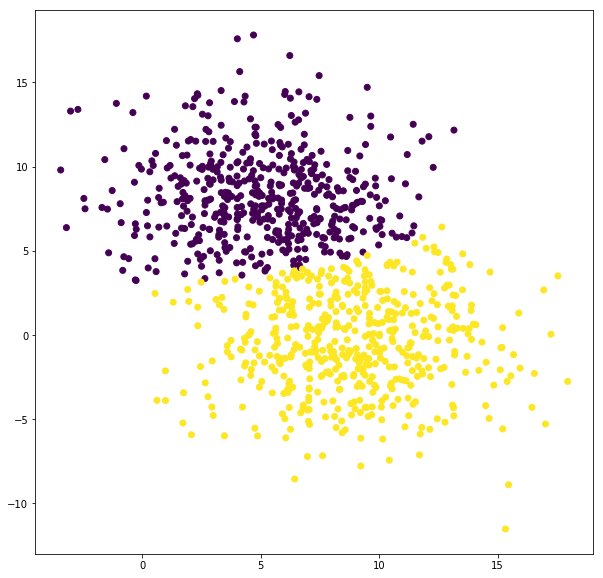

In [400]:
plt.figure(figsize=(10, 10))
plt.scatter(x=x, y=z, c=pred)